In [43]:
import time

import cv2
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image

from itertools import groupby
from skimage import io
from tqdm import tqdm

import pycocotools.mask as mask_util

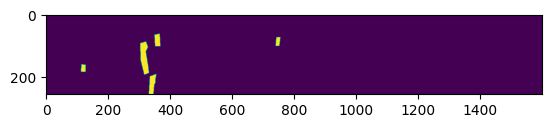

In [53]:
df = pd.read_csv('/home/eas/Enol/pycharm_projects/clipseg/third_party/severstal-steel-defect-detection/train.csv')
df.head()


In [52]:
def rle_decode(mask_rle, shape):
    """
    Decodes run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    :param rle_mask (str): Run-length encoded segmentation mask string.
    :param shape (tuple): (height, width) of array to return
    :return mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
    """
    # Splits the RLE string into a list of string by whitespaces.
    s = mask_rle.split()

    # This creates two numpy arrays, one with the RLE starts and one with their respective lengths
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

    # To obtain the end point we need to substract 1 to the length or start because the initial point counts.
    starts -= 1
    ends = starts + lengths

    # Create a 1D array of size H*W of zeros
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Fill this array with ones in the positions where there is a mask using the RLE information
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    # Reshape the 1D array into a 2D array so we can finally get the binary 2D mask.
    mask = mask.reshape(shape)
    return mask.T



In [46]:
def rle_encode(binary_matrix):
    array = binary_matrix.T.flatten()
    counting = False
    length = 0
    rle_code = []
    for pos, val in enumerate(array):
        if val == 1 and not counting:
            counting = True
            rle_code.append(str(pos + 1))
            length += 1
        elif val == 1 and counting:
            length += 1
        elif val == 0 and counting:
            counting = False
            rle_code.append(str(length))
            length = 0
    if counting:
        rle_code.append(str(length))
    return ' '.join(rle_code)

In [48]:
height = 1600
width = 256
read_path = '/home/eas/Enol/pycharm_projects/clipseg/third_party/severstal-steel-defect-detection/train_images/'
write_path = '/home/eas/Enol/pycharm_projects/clipseg/third_party/severstal-steel-defect-detection/train_subimages/'
new_df = pd.DataFrame(columns=['ImageId', 'ClassId', 'EncodedPixels'])
new_df['ClassId'] = new_df['ClassId'].astype(np.int64)

In [49]:
## Generate subimages
for filename in os.listdir(read_path):
    image = cv2.imread(read_path + filename)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    n_block = 1
    for x in range(0, 1600, 256):
        if n_block == 7:
            block = image_rgb[:, -256:, :]
        else:
            block = image_rgb[:, x:x+256, :]
        new_filename = write_path + filename[0:9] + f'_{n_block}' + '.jpg'
        plt.imsave(new_filename, block)
        n_block += 1

In [50]:
## Generate csv with mask information for defects in the subimages
for idx in range(0, len(df)):
    mask = rle_decode(df.iloc[idx]['EncodedPixels'], (height, width))
    class_id = str(df.iloc[idx]['ClassId'])
    image_id = str(df.iloc[idx]['ImageId'])[0:9]
    file = read_path + image_id + '.jpg'
    image = cv2.imread(file)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    n_block = 1
    for x in range(0, 1600, 256):
        if n_block == 7:
            mask_block = mask_rgb[:, -256:, :]
        else:
            mask_block = mask_rgb[:, x:x+256, :]
        
        mask_block = mask_block
        if np.sum(mask_block) > 0:
            new_entry = {'ImageId': image_id + f'_{n_block}' + '.jpg', 'ClassId': class_id, 'EncodedPixels': rle_encode(mask_block)}
            new_df = pd.concat([new_df, pd.DataFrame([new_entry])], ignore_index=True)
        n_block += 1  
        


In [51]:
new_df.to_csv('/home/eas/Enol/pycharm_projects/clipseg/third_party/severstal-steel-defect-detection/subimages.csv')